#  Decision Tree on Google PlayStore Apps 

这次我想通过使用决策树对 __[Kaggle 的 Google PlayStore 应用数据集](https://www.kaggle.com/lava18/google-play-store-apps)__ 进行分析，希望找出与应用__安装量__密切相关的因素，也是希望在工作上对我所在的海外部门的应用市场数据增长起到一定作用。

## 初始化

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

## 数据集初探

In [2]:
df = pd.read_csv('data/googleplaystore.csv')
print('Number of apps in the dataset : ' , len(df))
df.sample(10)

Number of apps in the dataset :  10841


App         Category  Rating  \
953                  HBO GO: Stream with TV Package    ENTERTAINMENT     3.8   
6504                                    BN Mi Banco         BUSINESS     3.0   
7205                            Ultra CE calculator           SPORTS     4.2   
6488                             BAMMS for BM 1Park     PRODUCTIVITY     NaN   
872                             Cinematic Cinematic    ENTERTAINMENT     4.4   
4465   Popsicle Launcher for Android P 9.0 launcher  PERSONALIZATION     NaN   
10273                     Fan App for Portsmouth FC           SPORTS     4.5   
8745                                  World Webcams          WEATHER     3.7   
554                   Just She - Top Lesbian Dating           DATING     1.9   
7380                                   CI Staff App        LIFESTYLE     NaN   

      Reviews                Size     Installs  Type  Price Content Rating  \
953     87723                 32M  10,000,000+  Free      0           Teen   
6504      597                 17M     100,000+  Free      0       Everyone   
7205       28                7.3M       1,000+  Free      0       Everyone   
6488        7                 10M          50+  Free      0       Everyone   
872     37000                 15M   1,000,000+  Free      0     Mature 17+   
4465        0                5.5M           0+  Paid  $1.49       Everyone   
10273      53                 12M       1,000+  Free      0           Teen   
8745     7896  Varies with device   1,000,000+  Free      0       Everyone   
554       953                 19M     100,000+  Free      0     Mature 17+   
7380        0                 10M          10+  Free      0       Everyone   

                Genres       Last Updated Current Ver         Android Ver  
953      Entertainment      July 19, 2018  16.0.0.437          4.1 and up  
6504          Business      July 12, 2018         9.0          5.0 and up  
7205            Sports      June 17, 2018        1.52        4.0.3 and up  
6488      Productivity      July 19, 2018       1.3.2          4.1 and up  
872      Entertainment      June 21, 2018       4.0.5          4.1 and up  
4465   Personalization      July 11, 2018         1.1          4.2 and up  
10273           Sports     August 6, 2016      060816          4.2 and up  
8745           Weather  November 25, 2013         1.6  Varies with device  
554             Dating      July 18, 2018       6.3.7          5.0 and up  
7380         Lifestyle    October 4, 2017       1.0.7          4.1 and up


可以看出数据集里对每一个应用共有 13 种属性的定义，根据 Title 就能很直观的明白其意义。
这里我将**安装量**(*Installs*)作为目标，希望找到 App 的其他信息与其的对应关系。

## 数据预处理

In [3]:
# 打印某个属性的分布信息
def printInfos(feature):
    print( len(df[feature].unique()) , feature)
    print("\n", df[feature].unique())
    
    
# 打印整个表格的基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


可以看出数据里还是有一些属性为空的条目，处理这些空字段有几种方法，
比如，可以直接移除含有空字段的条目，但考虑到缺失的占比不小，直接删除会对数据的数量造成影响，所以这里采取了取**中位数补齐**的方式。

In [4]:
df['Rating'] = df['Rating'].fillna(df['Rating'].median())
printInfos('Rating')

40 Rating

 [ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   4.8  4.9  3.6
  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.   2.9
  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]


我们知道一个 App 的 Rating 值应该在 1 - 5之间，最后出现的 19.0 的值是错误的

In [5]:
index = df[df['Rating'] == 19.].index
print(df.loc[index])

                                           App Category  Rating Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M   

         Size Installs Type     Price Content Rating             Genres  \
10472  1,000+     Free    0  Everyone            NaN  February 11, 2018   

      Last Updated Current Ver Android Ver  
10472       1.0.19  4.0 and up         NaN  


可以看出这条数据的分类也非常奇怪的是一个数字，所以我打算丢弃这条有多处明显错误信息的数据

39 Rating

 [4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.2 4.6 3.2 4.  4.8 4.9 3.6 3.7 3.3 3.4 3.5
 3.1 5.  2.6 3.  1.9 2.5 2.8 2.7 1.  2.9 2.3 2.2 1.7 2.  1.8 2.4 1.6 2.1
 1.4 1.5 1.2]


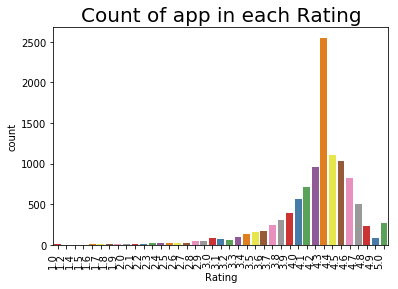

In [6]:
df = df.drop(index)
printInfos('Rating')

def visualFeatureCounting(feature):
    g = sns.countplot(x=feature,data=df, palette = "Set1")
    g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
    g
    plt.title('Count of app in each ' + feature, size = 20)
    
    
visualFeatureCounting('Rating')

如上述统计信息所示，删除该条数据后，Rating 分布已经正常

剩下的属性里缺失字段的数量都在个位数级别，故这里直接将含有空值的条目丢弃。

In [7]:
# Removing NaN values
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            10840 non-null float64
Reviews           10840 non-null object
Size              10840 non-null object
Installs          10840 non-null object
Type              10839 non-null object
Price             10840 non-null object
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10832 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.2+ MB


因为用来区分 App 收费与否的 Type 属性可以完全用 Price 属性表示，所以这里我们选择丢弃这个属性，
此外，个人认为下载量与 App 当前的版本属性 Current Ver 关系不大，以及表示多重分类的 Genres 属性跟主分类 Category 冲突。
所以在之后的 Feature 选取中都不会考虑这些属性（丢弃）。

## Categorical Data Encoding

在应用到决策树算法之前，我们需要将属性值数值化，将连续的数值转为离散的可分类的。

#### 将内容评级的文本表示转化为数字，数字越高代表限制级别越高

In [9]:
printInfos('Content Rating')

6 Content Rating

 ['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated']


In [10]:
def map_content_rating(content_rating):
    if 'Teen' in content_rating:
        return 1
    elif 'Everyone 10+' in content_rating:
        return 2
    elif 'Mature 17+' in content_rating:
        return 3
    elif 'Adults only 18+' in content_rating:
        return 4
    else:
        return 0

    
# Encode Content Rating features
df['Content Rating'] = df['Content Rating'].map(map_content_rating)
printInfos('Content Rating')

5 Content Rating

 [0 1 2 3 4]


#### 将用户 Review 数以 10 个数量级为单位划分

In [11]:
def map_reviews(number):
    number = int(number)
    if number < 10:
        return 1
    elif number < 100:
        return 2
    elif number < 1000:
        return 3
    elif number < 10000:
        return 4
    elif number < 100000:
        return 5
    elif number < 1000000:
        return 6
    elif number < 10000000:
        return 7
    else:
        return 8

8 Reviews

 [3 5 6 4 2 1 7 8]


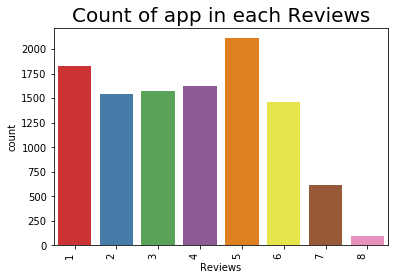

In [12]:
df['Reviews'] = df['Reviews'].map(map_reviews)

printInfos('Reviews')

visualFeatureCounting('Reviews')

#### 将 App 大小以 M 为单位划分

7 Size

 [3 2 4 1 0 5 6]


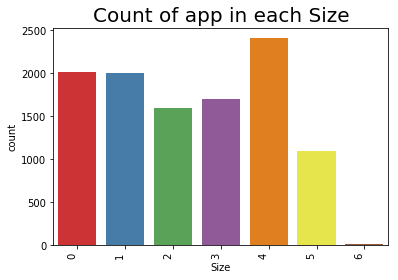

In [13]:
def map_size(size):
    if 'M' in size:
        x = float(size[:-1])
        if x < 5.0:
            return 1
        elif x < 10.0:
            return 2
        elif x < 20.0:
            return 3
        elif x < 50.0:
            return 4
        elif x < 100.0:
            return 5
        else:
            return 6
    else:
        return 0

    
df['Size'] = df['Size'].map(map_size)

printInfos('Size')

visualFeatureCounting('Size')

#### 将应用对 Android 版本的最低要求也同样由文本转为正确的数值

In [14]:
printInfos('Android Ver')

34 Android Ver

 ['4.0.3 and up' '4.2 and up' '4.4 and up' '2.3 and up' '3.0 and up'
 '4.1 and up' '4.0 and up' '2.3.3 and up' 'Varies with device'
 '2.2 and up' '5.0 and up' '6.0 and up' '1.6 and up' '1.5 and up'
 '2.1 and up' '7.0 and up' '5.1 and up' '4.3 and up' '4.0.3 - 7.1.1'
 '2.0 and up' '3.2 and up' '4.4W and up' '7.1 and up' '7.0 - 7.1.1'
 '8.0 and up' '5.0 - 8.0' '3.1 and up' '2.0.1 and up' '4.1 - 7.1.1' nan
 '5.0 - 6.0' '1.0 and up' '2.2 - 7.1.1' '5.0 - 7.1.1']


9 Android Ver

 [4 2 3 0 5 6 1 7 8]


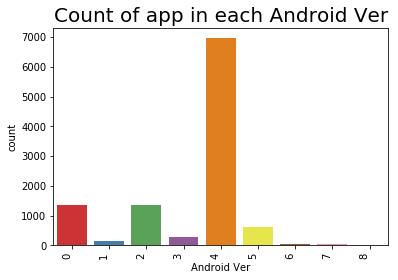

In [15]:
def map_version(version):
    version = str(version)
    if version.startswith("1."):
        return 1
    elif version.startswith("2."):
        return 2
    elif version.startswith("3."):
        return 3
    elif version.startswith("4."):
        return 4
    elif version.startswith("5."):
        return 5
    elif version.startswith("6."):
        return 6
    elif version.startswith("7."):
        return 7
    elif version.startswith("8."):
        return 8
    else:
        return 0

    
df['Android Ver'] = df['Android Ver'].map(map_version)

printInfos('Android Ver')
visualFeatureCounting('Android Ver')

#### 剩下一些属性值的通用处理

In [16]:
# get_dummies creates a new dataframe which consists of zeros and ones
df['App'] = pd.get_dummies(df['App'])
df['Last Updated'] = pd.get_dummies(df['Last Updated'])

# Encode Category features
le = preprocessing.LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))


#### 作为检测目标的安装数 Installs 的处理
这里只分了 百万级、千万级和其他 3个分类

3 Installs

 [0 1 2]


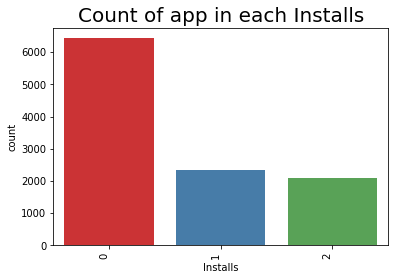

In [17]:
def map_installs(number):
    number = int(number)
    if number < 1000000:
        return 0
    elif number < 10000000:
        return 1
    else:
        return 2

    
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))
df['Installs'] = df['Installs'].map(map_installs)

printInfos('Installs')

visualFeatureCounting('Installs')

根据之前的分析，这里忽略 'Type', 'Current Ver', 'Genres'  这几个特征值对结果的影响

#### 生成数据集以及训练、测试集的划分

In [18]:
X_all = df.drop(['Installs', 'Type', 'Current Ver', 'Genres'], axis=1)
y_all = df['Installs']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=10)

### 使用决策树预测分类

这里使用决策树分类器的默认设置，
对应的分类标准是  Gini impurity 算法 - 相对 Information gain 有更快的计算速度<br>
策略采用的 best 最优而非随机最优<br>
没有设定最大深度，min_samples_split = 2，  min_samples_leaf = 1， <br>
max_features = 处理后非 label 的所有特征

In [19]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)


predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8685424354243543


### 使用 RandomForest 计算

In [ ]:
# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

这里通过 GridSearchCV 将排列组合的方式试用算法参数并最终选择一个最优的参数组合来最终计算 <br>
可以看出相比 DT，准确率上升了一些。

In [ ]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

### AdaBoost

In [ ]:
clf = AdaBoostClassifier(n_estimators=100)

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9],
             'algorithm' : ['SAMME', 'SAMME.R']}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

### 感想
通过决策树系列的计算与预测，可以推论出一个 App 在应用市场的下载量与其基本信息有着密切的关系，将来我们可以通过优化 Apk 的大小，提升用户评分等方式提升下载量实现增长。<br>
在实验中，一开始没有将下载的预测分类做简化处理，而是直接按市场的分类划分为 10 几个，运算结果非常糟糕，只有 50% 左右。
后来发现相比数据的预处理以及 结合实际场景的 **Categorical Data Encoding**，缩减 label 的分类对结果的影响有显著提升，如果只按千万下载量划分，准确率更会提升到 90%+，这是否意味着决策树更适合预测结果分类相对较少的场景呢？

In [22]:
X_all.sample(2)

App  Category  Rating  Reviews  Size Price  Content Rating  \
7266     0        15     2.2        1     2     0               0   
10342    0         3     4.3        1     0     0               0   

       Last Updated  Android Ver  
7266              0            4  
10342             0            3

In [21]:
import graphviz 

dot_data = tree.export_graphviz(clf, out_file=None, 
                      # feature_names=iris.feature_names,  
                      # class_names=iris.target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 